In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Resolve project root (assuming notebook is in notebooks/)
PROJECT_ROOT = Path.cwd().parents[1]

# Path to model output
RES_PATH = (
    PROJECT_ROOT
    / "data"
    / "processed"
    / "model_output"
    / "variant_attention_deltas_100bp.pkl"
)

# Load results
res = pd.read_pickle(RES_PATH)

print("res shape:", res.shape)
print("columns:", res.columns.tolist())
res.head()


In [25]:
# Normalize ClinicalSignificance to lowercase (benign/pathogenic/vus/etc.)
if "ClinicalSignificance" in res.columns:
    res["ClinicalSignificance"] = res["ClinicalSignificance"].astype(str).str.strip().str.lower()


In [26]:
import pandas as pd
import numpy as np

# load pickle
#res = pd.read_pickle("variant_attention_deltas_100bp.pkl")

# ---------- helper functions ----------
def compute_asymmetry(profile, var_idx):
    profile = np.asarray(profile)
    upstream = profile[:var_idx]
    downstream = profile[var_idx + 1:]
    total = profile.sum()
    if total == 0:
        return np.nan
    return (downstream.sum() - upstream.sum()) / total

def compute_variant_rank(profile, var_idx):
    profile = np.asarray(profile)
    ranks = (-profile).argsort().argsort() + 1  # rank 1 = largest delta
    return ranks[var_idx]

# ---------- A) normalized locality ----------
res["local_fraction_w5"] = (
    res["local_sum_abs_delta_received_w5"] /
    res["sum_abs_delta_received"]
)

# ---------- B) spatial asymmetry ----------
res["delta_asymmetry"] = res.apply(
    lambda r: compute_asymmetry(
        r["dist_profile_abs_delta_received"],
        r["variant_token_index"]
    ),
    axis=1
)

# ---------- C) variant-token rank ----------
res["variant_token_delta_rank"] = res.apply(
    lambda r: compute_variant_rank(
        r["dist_profile_abs_delta_received"],
        r["variant_token_index"]
    ),
    axis=1
)



In [4]:
rows = []

# Keep rows that have the profile and labels
tmp = res.dropna(
    subset=[
        "variant_token_index",
        "dist_profile_abs_delta_received",
        "functional_class",
        "ClinicalSignificance",
    ]
).copy()

# Convert the profile column from string -> list if needed
# If your CSV saved lists like "[0.1, 0.2, ...]" this fixes it
def _to_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        if x.startswith("[") and x.endswith("]"):
            return [float(v) if v != "nan" else np.nan for v in x[1:-1].split(",")]
    return x

tmp["dist_profile_abs_delta_received"] = tmp["dist_profile_abs_delta_received"].apply(_to_list)

# Explode each per-variant profile into one row per distance
for _, r in tmp.iterrows():
    prof = r["dist_profile_abs_delta_received"]
    if not isinstance(prof, (list, tuple, np.ndarray)):
        continue

    for d, v in enumerate(prof):
        if pd.notna(v):
            rows.append({
                "variant_token_index": r["variant_token_index"],
                "ClinicalSignificance": r["ClinicalSignificance"],
                "functional_class": r["functional_class"],
                "distance": d,
                "abs_delta_received": float(v),
            })

decay = pd.DataFrame(rows)

print("decay shape:", decay.shape)
decay.head()


decay shape: (12987, 5)


,variant_token_index,ClinicalSignificance,functional_class,distance,abs_delta_received
0,9,benign,missense,0,0.261932
1,9,benign,missense,1,0.034199
2,9,benign,missense,2,0.155622
3,9,benign,missense,3,0.146983
4,9,benign,missense,4,0.095952


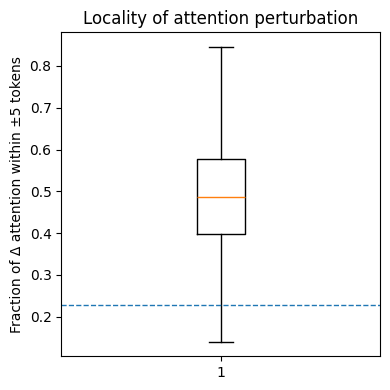

Median local fraction: 0.486
Mean local fraction: 0.488


In [27]:
import matplotlib.pyplot as plt
import numpy as np

# drop NaNs just in case
vals = res["local_fraction_w5"].dropna().values

plt.figure(figsize=(4, 4))
plt.boxplot(vals, showfliers=False)
plt.axhline(5 / res["token_length"].iloc[0], linestyle="--", linewidth=1)

plt.ylabel("Fraction of Δ attention within ±5 tokens")
plt.title("Locality of attention perturbation")

plt.tight_layout()
plt.show()

print(f"Median local fraction: {np.median(vals):.3f}")
print(f"Mean local fraction: {np.mean(vals):.3f}")


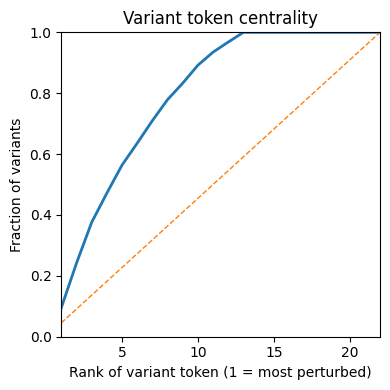

Fraction with rank = 1: 0.095
Fraction with rank ≤ 3: 0.375
Median rank: 5.0 out of 22


In [28]:
import numpy as np
import matplotlib.pyplot as plt

# ranks: 1 = highest delta token
ranks = res["variant_token_delta_rank"].dropna().astype(int).values
n_tokens = int(res["token_length"].iloc[0])

# empirical CDF
xs = np.arange(1, n_tokens + 1)
cdf = np.array([(ranks <= x).mean() for x in xs])

plt.figure(figsize=(4, 4))
plt.plot(xs, cdf, linewidth=2)

# null expectation if the variant token's rank were random among tokens
plt.plot(xs, xs / n_tokens, linestyle="--", linewidth=1)

plt.xlim(1, n_tokens)
plt.ylim(0, 1)
plt.xlabel("Rank of variant token (1 = most perturbed)")
plt.ylabel("Fraction of variants")
plt.title("Variant token centrality")

plt.tight_layout()
plt.show()

print(f"Fraction with rank = 1: {(ranks == 1).mean():.3f}")
print(f"Fraction with rank ≤ 3: {(ranks <= 3).mean():.3f}")
print(f"Median rank: {np.median(ranks):.1f} out of {n_tokens}")


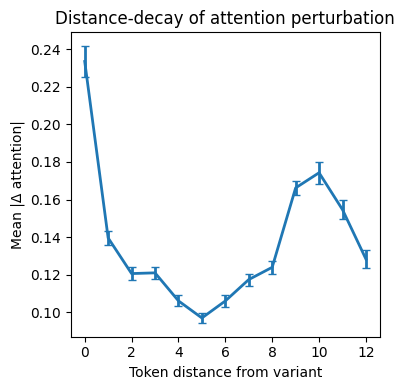

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# stack distance profiles
profiles = np.vstack(
    res["dist_profile_abs_delta_received"].dropna().values
)

mean_profile = profiles.mean(axis=0)
sem_profile = profiles.std(axis=0) / np.sqrt(profiles.shape[0])

distances = np.arange(len(mean_profile))

plt.figure(figsize=(4, 4))
plt.errorbar(
    distances,
    mean_profile,
    yerr=sem_profile,
    linewidth=2,
    capsize=3
)

plt.xlabel("Token distance from variant")
plt.ylabel("Mean |Δ attention|")
plt.title("Distance-decay of attention perturbation")

plt.tight_layout()
plt.show()


/var/folders/t7/xlq3thrd3bn646lmxy5vp3800000gn/T/ipykernel_27953/2496501429.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


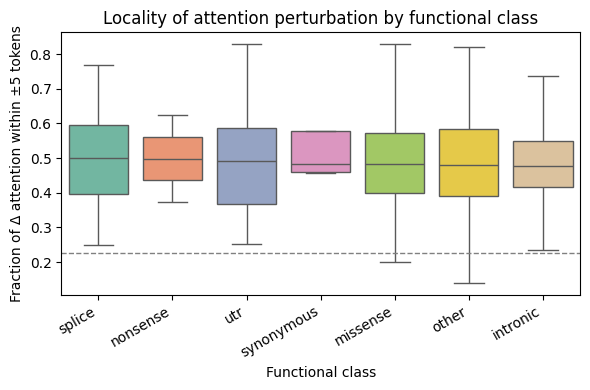

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

res_fc = res.dropna(subset=["local_fraction_w5", "functional_class"]).copy()

order = (
    res_fc
    .groupby("functional_class")["local_fraction_w5"]
    .median()
    .sort_values(ascending=False)
    .index
)

# professional categorical palette
palette = sns.color_palette("Set2", n_colors=len(order))
palette_dict = dict(zip(order, palette))

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=res_fc,
    x="functional_class",
    y="local_fraction_w5",
    order=order,
    palette=palette_dict,
    showfliers=False
)

# null expectation line
null_frac = 5 / res["token_length"].iloc[0]
plt.axhline(null_frac, linestyle="--", linewidth=1, color="gray")

plt.xlabel("Functional class")
plt.ylabel("Fraction of Δ attention within ±5 tokens")
plt.title("Locality of attention perturbation by functional class")

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


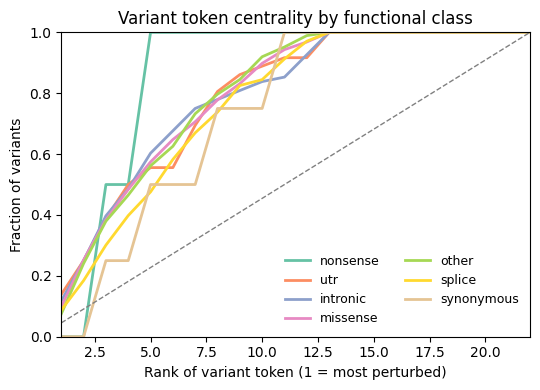

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# keep needed columns
tmp = res.dropna(subset=["variant_token_delta_rank", "functional_class"]).copy()
tmp["variant_token_delta_rank"] = tmp["variant_token_delta_rank"].astype(int)

# token length (assumes constant)
n_tokens = int(res["token_length"].iloc[0])
xs = np.arange(1, n_tokens + 1)

# order classes by median rank (lower = more central)
class_order = (
    tmp.groupby("functional_class")["variant_token_delta_rank"]
       .median()
       .sort_values()
       .index
)

# palette consistent with your Figure 2A (Set2)
import seaborn as sns
palette = sns.color_palette("Set2", n_colors=len(class_order))
color_map = dict(zip(class_order, palette))

plt.figure(figsize=(5.5, 4))

# plot a CDF curve per class
for cls in class_order:
    ranks = tmp.loc[tmp["functional_class"] == cls, "variant_token_delta_rank"].values
    cdf = np.array([(ranks <= x).mean() for x in xs])
    plt.plot(xs, cdf, linewidth=2, label=f"{cls}", color=color_map[cls])

# null expectation
plt.plot(xs, xs / n_tokens, linestyle="--", linewidth=1, color="gray")

plt.xlim(1, n_tokens)
plt.ylim(0, 1)
plt.xlabel("Rank of variant token (1 = most perturbed)")
plt.ylabel("Fraction of variants")
plt.title("Variant token centrality by functional class")

plt.legend(frameon=False, fontsize=9, ncol=2)
plt.tight_layout()
plt.show()


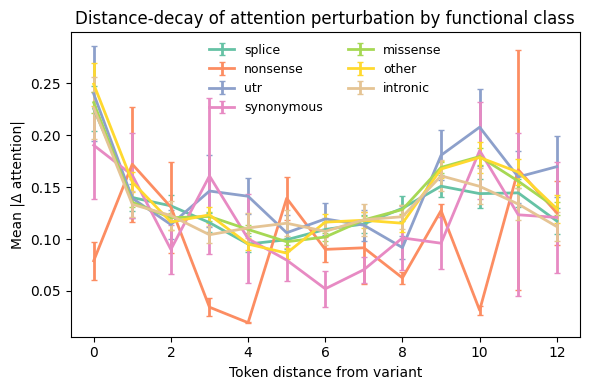

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# drop rows with missing data
tmp = res.dropna(subset=["dist_profile_abs_delta_received", "functional_class"]).copy()

# get token distances
n_tokens = len(tmp["dist_profile_abs_delta_received"].iloc[0])
distances = np.arange(n_tokens)

# class order (same as Figure 2A if possible)
class_order = (
    tmp.groupby("functional_class")["local_fraction_w5"]
       .median()
       .sort_values(ascending=False)
       .index
)

# color palette (match Figure 2A / 2B)
palette = sns.color_palette("Set2", n_colors=len(class_order))
color_map = dict(zip(class_order, palette))

plt.figure(figsize=(6, 4))

for cls in class_order:
    profiles = np.vstack(
        tmp.loc[tmp["functional_class"] == cls, "dist_profile_abs_delta_received"]
    )
    mean_profile = profiles.mean(axis=0)
    sem_profile = profiles.std(axis=0) / np.sqrt(profiles.shape[0])

    plt.errorbar(
        distances,
        mean_profile,
        yerr=sem_profile,
        linewidth=2,
        capsize=2,
        label=cls,
        color=color_map[cls]
    )

plt.xlabel("Token distance from variant")
plt.ylabel("Mean |Δ attention|")
plt.title("Distance-decay of attention perturbation by functional class")

plt.legend(frameon=False, fontsize=9, ncol=2)
plt.tight_layout()
plt.show()


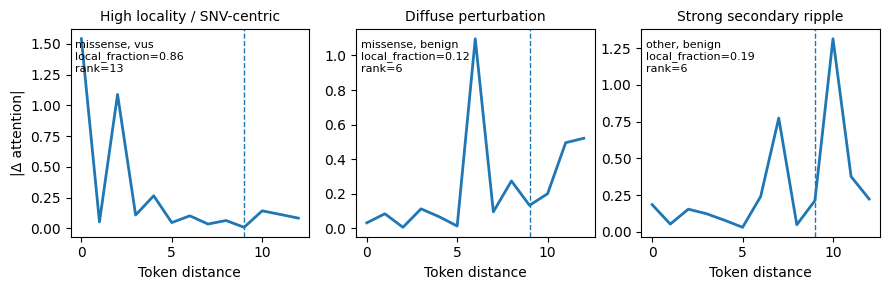

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# work on a clean subset
tmp = res.dropna(subset=[
    "dist_profile_abs_delta_received",
    "local_fraction_w5",
    "variant_token_delta_rank",
    "functional_class",
    "ClinicalSignificance"
]).copy()

# --- select representative variants ---

# A: high locality, high centrality
v_high_local = tmp.sort_values(
    ["local_fraction_w5", "variant_token_delta_rank"],
    ascending=[False, True]
).iloc[0]

# B: low locality
v_low_local = tmp.sort_values("local_fraction_w5").iloc[0]

# C: strong secondary ripple (max around distance 8–10)
def secondary_peak(profile):
    prof = np.asarray(profile)
    return prof[8:11].max()

tmp["secondary_peak"] = tmp["dist_profile_abs_delta_received"].apply(secondary_peak)
v_secondary = tmp.sort_values("secondary_peak", ascending=False).iloc[0]

variants = [v_high_local, v_low_local, v_secondary]
titles = [
    "High locality / SNV-centric",
    "Diffuse perturbation",
    "Strong secondary ripple"
]

# --- plot ---
plt.figure(figsize=(9, 3))

for i, (v, title) in enumerate(zip(variants, titles), 1):
    profile = np.asarray(v["dist_profile_abs_delta_received"])
    distances = np.arange(len(profile))

    plt.subplot(1, 3, i)
    plt.plot(distances, profile, linewidth=2)
    plt.axvline(v["variant_token_index"], linestyle="--", linewidth=1)

    plt.title(title, fontsize=10)
    plt.xlabel("Token distance")
    if i == 1:
        plt.ylabel("|Δ attention|")

    plt.text(
        0.02, 0.95,
        f'{v["functional_class"]}, {v["ClinicalSignificance"]}\n'
        f'local_fraction={v["local_fraction_w5"]:.2f}\n'
        f'rank={int(v["variant_token_delta_rank"])}',
        transform=plt.gca().transAxes,
        fontsize=8,
        verticalalignment="top"
    )

plt.tight_layout()
plt.show()


In [36]:
print(len(variants))
for i, v in enumerate(variants):
    print(i, type(v), len(v["dist_profile_abs_delta_received"]),
          np.sum(v["dist_profile_abs_delta_received"]))


3
0 <class 'pandas.core.series.Series'> 51 nan
1 <class 'pandas.core.series.Series'> 51 nan
2 <class 'pandas.core.series.Series'> 51 nan


AttributeError: module 'matplotlib.pyplot' has no attribute 'l'

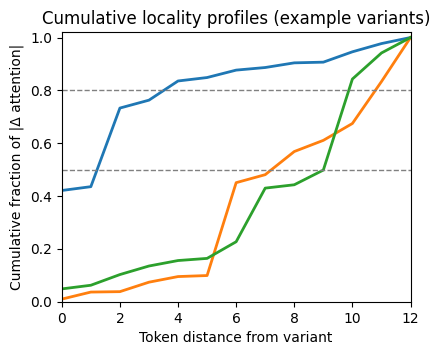

In [38]:
import numpy as np
import matplotlib.pyplot as plt

labels = [
    "High locality / SNV-centric",
    "Diffuse perturbation",
    "Strong secondary ripple"
]

plt.figure(figsize=(4.5, 3.5))

for v, label in zip(variants, labels):
    prof = np.asarray(v["dist_profile_abs_delta_received"], dtype=float)

    # replace NaNs with 0 so sums are valid
    prof = prof[:13]

    total = prof.sum()
    if total <= 0:
        print(f"Skipping {label}: total is {total}")
        continue

    cumfrac = np.cumsum(prof) / total
    x = np.arange(len(cumfrac))

    plt.plot(x, cumfrac, linewidth=2, label=label)

plt.axhline(0.5, linestyle="--", linewidth=1, color="gray")
plt.axhline(0.8, linestyle="--", linewidth=1, color="gray")

plt.xlabel("Token distance from variant")
plt.ylabel("Cumulative fraction of |Δ attention|")
plt.title("Cumulative locality profiles (example variants)")
plt.ylim(0, 1.02)
plt.xlim(0, len(cumfrac) - 1)

plt.l


In [39]:
# --- select additional representative variants ---

# 4) Another high locality / SNV-centric (exclude the first)
v_high_local_2 = (
    tmp.sort_values(
        ["local_fraction_w5", "variant_token_delta_rank"],
        ascending=[False, True]
    )
    .iloc[1]
)

# 5) Another diffuse perturbation
v_low_local_2 = tmp.sort_values("local_fraction_w5").iloc[1]

# 6) Another strong secondary ripple
v_secondary_2 = (
    tmp.sort_values("secondary_peak", ascending=False)
    .iloc[1]
)

variants_extended = [
    v_high_local, v_high_local_2,
    v_low_local, v_low_local_2,
    v_secondary, v_secondary_2
]

titles_extended = [
    "High locality / SNV-centric (1)",
    "High locality / SNV-centric (2)",
    "Diffuse perturbation (1)",
    "Diffuse perturbation (2)",
    "Strong secondary ripple (1)",
    "Strong secondary ripple (2)",
]


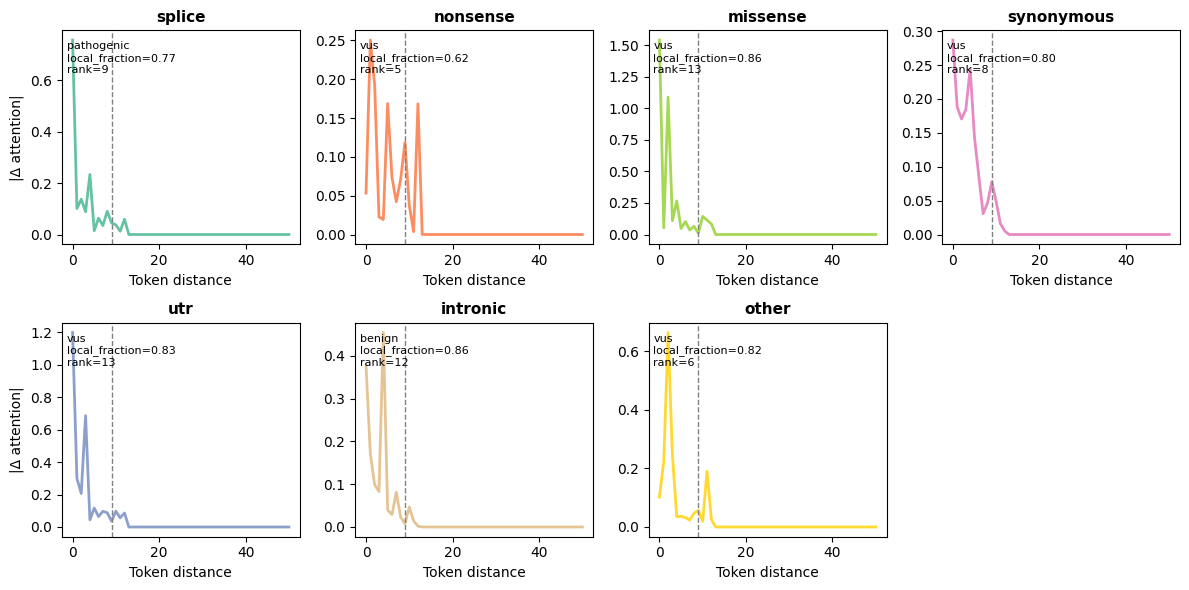

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Functional-class color palette (same as Figure 2)
# ----------------------------
class_palette = {
    "splice": "#66C2A5",
    "nonsense": "#FC8D62",
    "utr": "#8DA0CB",
    "synonymous": "#E78AC3",
    "missense": "#A6D854",
    "other": "#FFD92F",
    "intronic": "#E5C494",
}

# ----------------------------
# Clean data + pick one variant per functional class
# (highest locality per class)
# ----------------------------
tmp = res.dropna(subset=[
    "dist_profile_abs_delta_received",
    "local_fraction_w5",
    "variant_token_delta_rank",
    "functional_class",
    "ClinicalSignificance"
]).copy()

picked = (
    tmp.sort_values("local_fraction_w5", ascending=False)
       .groupby("functional_class", as_index=False)
       .head(1)
       .reset_index(drop=True)
)

# Optional: enforce a consistent class order
class_order = ["splice", "nonsense", "missense", "synonymous", "utr", "intronic", "other"]
picked["functional_class"] = pd.Categorical(
    picked["functional_class"],
    categories=class_order,
    ordered=True
)
picked = picked.sort_values("functional_class")

# ----------------------------
# Plot: one facet per functional class
# ----------------------------
n = len(picked)
ncols = 4
nrows = int(np.ceil(n / ncols))

plt.figure(figsize=(12, 6))

for i, (_, v) in enumerate(picked.iterrows(), 1):
    prof = np.asarray(v["dist_profile_abs_delta_received"], dtype=float)
    prof = np.nan_to_num(prof, nan=0.0)

    # Optional: restrict to 0–12 distances to match earlier figures
    # prof = prof[:13]

    x = np.arange(len(prof))
    fc = v["functional_class"]
    color = class_palette.get(fc, "gray")

    plt.subplot(nrows, ncols, i)
    plt.plot(x, prof, linewidth=2, color=color)
    plt.axvline(v["variant_token_index"], linestyle="--", linewidth=1, color="gray")

    # Functional class as panel title
    plt.title(str(fc), fontsize=11, fontweight="bold")

    plt.xlabel("Token distance")
    if i in [1, 5]:
        plt.ylabel("|Δ attention|")

    # Annotation block
    plt.text(
        0.02, 0.95,
        f'{v["ClinicalSignificance"]}\n'
        f'local_fraction={v["local_fraction_w5"]:.2f}\n'
        f'rank={int(v["variant_token_delta_rank"])}',
        transform=plt.gca().transAxes,
        fontsize=8,
        verticalalignment="top"
    )

# Hide unused panels
for j in range(n + 1, nrows * ncols + 1):
    plt.subplot(nrows, ncols, j)
    plt.axis("off")

plt.tight_layout()
plt.show()
